<a href="https://colab.research.google.com/github/MMakovec/IJS_models/blob/gh-pages/Copy_of_UK_dale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- UK-dale dataset contains 5 houses, each house having its own directory with a different number of channels. Each channel represents an appliance that has its consumption measured. The original data shows consumption for every 5-6 seconds. I had to sum up all the appliances of each house in order to get a dataset on which I can predict the energy consumption of the whole house. 
- The dataset also includes a file with metadata for each house, telling us for example what type of house it is.

- Importing the needed libraries, the names of all the files and mounting google drive.

In [1]:
import shutil
import pathlib
import os
import pandas as pd
import numpy as np
from google.colab import drive
import pickle
import functools

drive.mount("/content/drive")

house_1_files = os.listdir('/content/drive/MyDrive/IJS/UK-dale/house_1/')
house_2_files = os.listdir('/content/drive/MyDrive/IJS/UK-dale/house_2/')
house_3_files = os.listdir('/content/drive/MyDrive/IJS/UK-dale/house_3/')
house_4_files = os.listdir('/content/drive/MyDrive/IJS/UK-dale/house_4/')
house_5_files = os.listdir('/content/drive/MyDrive/IJS/UK-dale/house_5/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
  import matplotlib.pyplot as plt
  import seaborn as sns

  from keras.callbacks import ModelCheckpoint
  from keras.models import Sequential
  from tensorflow.keras.layers import LSTM
  from tensorflow.keras.layers import Dense, Dropout
  from tensorflow.keras.metrics import mean_absolute_percentage_error
  import warnings 
  warnings.filterwarnings('ignore')
  warnings.filterwarnings('ignore', category=DeprecationWarning)

  from sklearn.model_selection import train_test_split
  from sklearn.metrics import mean_absolute_error 
  from sklearn.preprocessing import StandardScaler
  from sklearn.model_selection import KFold
  from sklearn.model_selection import cross_val_score
  from sklearn.pipeline import Pipeline
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.model_selection import GridSearchCV
  from sklearn.datasets import make_classification
  from sklearn.model_selection import cross_val_predict
  import xgboost as xgb

- Copying all the files from google drive to the disk.

In [3]:
granularity = ''
while granularity != '60min' and granularity != '5min':
  granularity = input("Enter sample time interval (5min/60min): ")
  if granularity != '60min' and granularity != '5min':
    print('Please pick one of the available options: 5min or 60min')

Enter sample time interval (5min/60min): 5min


- For each house in the dataset a few steps were needed before I was able to sum them.
- House 1 had to be split up as it is by far the biggest dataset and on top of that it also has the most channels (it uses amost all of the available RAM in google colaboratory just from importing).

- House 1 follows same steps as other houses, just split up into two subsets.

- All other houses follow these steps:
  - Importing data
  - Getting the data in order to begin merging
  - Converting the datatypes
  - Resampling the data to every 5 minutes or 60 minutes, instead of every 5-6 seconds
  - Summing up everything
  - Deleting not needed variables to save RAM

- Function that sums two channels of house 1.

In [4]:
def read_house(num_channels, start_channel=0):
  house = {}
  for i in range(start_channel,num_channels,1):
    house['ch_'+str(i+1)] = pd.read_csv('channel_'+str(i+1)+'.dat',sep=' ', header=None)
  house['labels'] = pd.read_csv('labels.dat',sep=' ',header=None)
  return house

def sum_house(house, start_channel=1):
  house_array = []
  for i in range(start_channel,len(house)+start_channel-1,1):
    house['ch_'+str(i)].rename(columns={0:'ts',1:'energy_Wh'},inplace=True)
    house['ch_'+str(i)]['ts'] = pd.to_datetime(house['ch_'+str(i)]['ts'], unit='s')
    house['ch_'+str(i)].set_index(['ts'], inplace=True)
    house['ch_'+str(i)]['energy_Wh'] = house['ch_'+str(i)]['energy_Wh'].astype('float32')
    house_array.append(house['ch_'+str(i)].resample(granularity).aggregate(np.mean))                           
  hs = functools.reduce(lambda a, b: a.add(b, fill_value=0), house_array)
  hs = hs[(hs != 0).all(1)]
  return hs

In [5]:
# You can use this code for house_1 data if you have available ram.

'''

##############    hs_1    ###################

for file_name in house_1_files:
    full_file_name = os.path.join('/content/drive/MyDrive/IJS/UK-dale/house_1/', file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, "/content")

house_1 = read_house(num_channels = 53)

hs_1 = sum_house(house_1)

del house_1

'''

'\n\n##############    hs_1    ###################\n\nfor file_name in house_1_files:\n    full_file_name = os.path.join(\'/content/drive/MyDrive/IJS/UK-dale/house_1/\', file_name)\n    if os.path.isfile(full_file_name):\n        shutil.copy(full_file_name, "/content")\n\nhouse_1 = read_house(num_channels = 53)\n\nhs_1 = sum_house(house_1)\n\ndel house_1\n\n'

In [6]:
# Code for google Colaboratory RAM


##############    hs_1    ###################

for file_name in house_1_files:
    full_file_name = os.path.join('/content/drive/MyDrive/IJS/UK-dale/house_1/', file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, "/content")

house_1 = read_house(num_channels = 25)

hs_1 = sum_house(house_1)

del house_1

house_1 = read_house(num_channels = 53, start_channel=25)

hs_1_1 = sum_house(house_1, start_channel=26)

del house_1

hs_1 = hs_1.add(hs_1_1, fill_value=0)

del hs_1_1

- Pickling out the result for later importing to save RAM.

In [7]:
pickle_out1 = open("hs_1.pkl", "wb")
pickle.dump(hs_1, pickle_out1)
pickle_out1.close()
del hs_1

In [8]:
##############    hs_2    ###################

for file_name in house_2_files:
    full_file_name = os.path.join('/content/drive/MyDrive/IJS/UK-dale/house_2/', file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, "/content")

house_2 = read_house(num_channels = 19)

hs_2 = sum_house(house_2)

del house_2

- Pickling out the result for later importing to save RAM.

In [9]:
pickle_out2 = open("hs_2.pkl", "wb")
pickle.dump(hs_2, pickle_out2)
pickle_out2.close()
del hs_2

In [10]:
##############    hs_3    ##################

for file_name in house_3_files:
    full_file_name = os.path.join('/content/drive/MyDrive/IJS/UK-dale/house_3/', file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, "/content")

house_3 = read_house(num_channels = 5)


hs_3 = sum_house(house_3)
hs_3.dropna(inplace=True)

del house_3

- Pickling out the result for later importing to save RAM.

In [11]:
pickle_out3 = open("hs_3.pkl", "wb")
pickle.dump(hs_3, pickle_out3)
pickle_out3.close()
del hs_3

In [12]:
##############    hs_4    ##################

for file_name in house_4_files:
    full_file_name = os.path.join('/content/drive/MyDrive/IJS/UK-dale/house_4/', file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, "/content")

house_4 = read_house(num_channels = 6)

hs_4 = sum_house(house_4)

del house_4

- Pickling out the result for later importing to save RAM.

In [13]:
pickle_out4 = open("hs_4.pkl", "wb")
pickle.dump(hs_4, pickle_out4)
pickle_out4.close()
del hs_4

In [14]:
##############    hs_5    ##################

for file_name in house_5_files:
    full_file_name = os.path.join('/content/drive/MyDrive/IJS/UK-dale/house_5/', file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, "/content")

house_5 = read_house(num_channels = 25)

hs_5 = sum_house(house_5)

del house_5

- Pickling out the result for later importing to save RAM.

In [15]:
pickle_out5 = open("hs_5.pkl", "wb")
pickle.dump(hs_5, pickle_out5)
pickle_out5.close()
del hs_5

- Deleting not needed variables to save RAM.

In [16]:
del house_2_files,house_3_files,house_4_files,house_5_files,full_file_name

- Importing the weather datasets for each year, which includes "max_air_temp" and "min_air_temp" for two periods each day, from 9am to 9pm and from 9pm to 9am (day and night).

In [17]:
def read_weather(weather_dict, i):
  weather = pd.read_csv('weather_'+str(i)+'.csv')
  weather_dict[str(i)] = weather[:-1]   # dropping last sample, which just marks the end
  return weather_dict

In [18]:
weather_files = os.listdir('/content/drive/MyDrive/IJS/UK-dale/Weather/')

for file_name in weather_files:
    full_file_name = os.path.join('/content/drive/MyDrive/IJS/UK-dale/Weather/', file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, "/content")

weather_dict = {}
for i in range(2012,2018,1):
  weather_dict = read_weather(weather_dict, i)

- Choosing the usefull features from the weather dataset and converting the timestamps into pandas DateTime format.
- Setting the timestamps as the index.
- Resampling (expanding) the dataset to show temperature for each hour and then using forward fill to fill in the missing values.

In [19]:
def sort_weather(weather_dict):
  for i in range(2012,2018,1):
    weather_dict[str(i)] = weather_dict[str(i)][['ob_end_time','max_air_temp','min_air_temp']]
    weather_dict[str(i)]['ob_end_time'] = pd.to_datetime(weather_dict[str(i)]['ob_end_time'])
    weather_dict[str(i)].set_index(['ob_end_time'],inplace=True)
    weather_dict[str(i)] = weather_dict[str(i)].resample('1H').aggregate(np.mean)
    weather_dict[str(i)].ffill(inplace=True)
  return weather_dict

In [20]:
weather_dict = sort_weather(weather_dict)

- Joining together weather datasets of each year.
- Reindexing the timestamp to every hour instead of twice a day, using forward fill to fill the missing values in the middle of the dataset and dropping the remaining missing values.
- Deleting not needed variables to save RAM.

In [21]:
weather = pd.concat([weather_dict['2012'],weather_dict['2013'],weather_dict['2014'],weather_dict['2015'],\
                     weather_dict['2016'],weather_dict['2017']])
ix = pd.date_range(start='2012-01-01', end='2017-12-31', freq='H')
weather = weather.reindex(ix)
weather.ffill(inplace=True)
weather.dropna(inplace=True)

del weather_dict

- Importing all of the house sums using pickle.

In [22]:
pickle_h1 = open("hs_1.pkl","rb")
hs_1 = pickle.load(pickle_h1)

pickle_h2 = open("hs_2.pkl","rb")
hs_2 = pickle.load(pickle_h2)

pickle_h3 = open("hs_3.pkl","rb")
hs_3 = pickle.load(pickle_h3)

pickle_h4 = open("hs_4.pkl","rb")
hs_4 = pickle.load(pickle_h4)

pickle_h5 = open("hs_5.pkl","rb")
hs_5 = pickle.load(pickle_h5)

# putting all houses in a dictionary

houses = [hs_1,hs_2,hs_3,hs_4,hs_5]
house = {}
i=1
for h in houses:
  house[str(i)] = h
  i+=1

del hs_1,hs_2,hs_3,hs_4,hs_5

- Merging house sums with weather and using forward fill to fill in the resulting missing values (the weather dataset at this point only has values for every hour which need to be forward filled to match the 5 minute resolution of the houses).
- dropping the missing values at the top of the dataset which remain even after ffill and we don't need them anyway (these values are before consumption was getting measured). 
- choosing the period of the dataset in which we have both energy consumption data and weather, because everything else is just weather data.
- Writing in the type of each house for the "type" feature.
- Converting data to use less memory.

In [23]:
def make_dataset(house_dict, weather):
  if granularity == '5min':
    date_ranges = [['2012-11-09 22:25:00','2017-04-26 17:30:00'],
                  ['2013-02-17 15:35:00','2013-10-10 05:15:00'],
                  ['2013-02-27 20:35:00','2013-04-08 05:15:00'],
                  ['2013-03-09 14:40:00','2013-10-01 05:15:00'],
                  ['2014-06-29 16:20:00','2014-11-13 17:55:00']]
  if granularity == '60min':
    date_ranges = [['2012-11-09 22:00:00','2017-04-26 17:00:00'],
                   ['2013-02-17 15:00:00','2013-10-10 05:00:00'],
                   ['2013-02-27 20:00:00','2013-04-08 05:00:00'],
                   ['2013-03-09 14:00:00','2013-10-01 05:00:00'],
                   ['2014-06-29 16:00:00','2014-11-13 17:00:00']]
  types = ['end-of-terrace',
           'end-of-terrace',
           0,
           'mid-terrace',
           'flat'] 
  for i in range(1,len(house_dict)+1,1):
    house_dict[str(i)] = pd.merge(house_dict[str(i)],weather,how='outer',right_index=True,left_index=True)
    house_dict[str(i)]['max_air_temp'].ffill(inplace=True)
    house_dict[str(i)]['min_air_temp'].ffill(inplace=True)
    house_dict[str(i)].dropna(inplace=True)
    house_dict[str(i)] = house_dict[str(i)][date_ranges[i-1][0]:date_ranges[i-1][1]]
    house_dict[str(i)]['type'] = types[i-1]
    house_dict[str(i)]['max_air_temp'] = house_dict[str(i)]['max_air_temp'].astype('float32')
    house_dict[str(i)]['min_air_temp'] = house_dict[str(i)]['min_air_temp'].astype('float32')
  return house_dict

In [24]:
house = make_dataset(house, weather)

- Reindexing the house data to have a sample for every five minutes, to be able to correctly shift the values. Before that, missing values didn't have their own sample containing NaNs, instead the sample was just missing, so some days had less samples than others.

In [25]:
if granularity=="5min":
  ix = pd.date_range(start='2012-11-09 22:25:00', end='2017-04-26 17:30:00', freq='5Min')    
  house['1'] = house['1'].reindex(ix)
  ix = pd.date_range(start='2013-02-17 15:35:00', end='2013-10-10 05:15:00', freq='5Min')
  house['2'] = house['2'].reindex(ix)
  ix = pd.date_range(start='2013-02-27 20:35:00', end='2013-04-08 05:15:00', freq='5Min')
  house['3'] = house['3'].reindex(ix)
  ix = pd.date_range(start='2013-03-09 14:40:00', end='2013-10-01 05:15:00', freq='5Min')
  house['4'] = house['4'].reindex(ix)
  ix = pd.date_range(start='2014-06-29 16:20:00', end='2014-11-13 17:55:00', freq='5Min')
  house['5'] = house['5'].reindex(ix)




if granularity == '60min':
  ix = pd.date_range(start='2012-11-09 22:00:00', end='2017-04-26 17:00:00', freq='60Min')    
  house['1'] = house['1'].reindex(ix)
  ix = pd.date_range(start='2013-02-17 15:00:00', end='2013-10-10 05:00:00', freq='60Min')
  house['2'] = house['2'].reindex(ix)
  ix = pd.date_range(start='2013-02-27 20:00:00', end='2013-04-08 05:00:00', freq='60Min')
  house['3'] = house['3'].reindex(ix)
  ix = pd.date_range(start='2013-03-09 14:00:00', end='2013-10-01 05:00:00', freq='60Min')
  house['4'] = house['4'].reindex(ix)
  ix = pd.date_range(start='2014-06-29 16:00:00', end='2014-11-13 17:00:00', freq='60Min')
  house['5'] = house['5'].reindex(ix)


- You can notice that the number of samples has increased, because we added Nans for missing values

In [26]:
house['5'].head()

,energy_Wh,max_air_temp,min_air_temp,type
2014-06-29 16:20:00,1969.310547,15.5,10.5,flat
2014-06-29 16:25:00,2864.362549,15.5,10.5,flat
2014-06-29 16:30:00,2464.433105,15.5,10.5,flat
2014-06-29 16:35:00,2520.632812,15.5,10.5,flat
2014-06-29 16:40:00,2309.479004,15.5,10.5,flat


- Making "energy_Wh_houseMean", "energy_Wh_daymean", "energy_per_hour", "energy_next_hour", "energy_hour_2", "energy_hour_3", "energy_previous_hour" if I want to do the predictions for every hour and also "energy diff","energy_5_min", "energy_10_min", "energy_15_min" features:
  - energy_Wh_houseMean: energy consumption mean of each house
  - energy_Wh_daymean: energy consumption mean of the previous day
  - energy_per_hour: energy consumption mean of current hour
  - energy_next_hour: energy consumption mean an hour into the future
  - energy_hour_2: energy consumption mean two hours into the future
  - energy_hour_3: energy consumption mean three hours into the future
  - energy_previous_hour: energy consumption mean of the previous hour
  - energy_diff: difference between current energy consumption and the previous sample energy consumption (5 minutes before)
  - energy_5_min: energy consumption 5 minutes into the future
  - energy_10_min: energy consumption 10 minutes into the future
  - energy_15_min: energy consumption 15 minutes into the future


In [27]:
def create_energy_features(house_dict,granularity):
  if granularity=='5min':
    for i in range(1,len(house_dict)+1,1):
      house_dict[str(i)]['energy_Wh_houseMean'] = np.mean(house_dict[str(i)]['energy_Wh'])
      house_dict[str(i)]['energy_Wh_daymean'] = house_dict[str(i)]['energy_Wh'].dropna().resample('1d').mean()
      house_dict[str(i)]['energy_Wh_daymean'].ffill(axis=0, inplace=True)
      house_dict[str(i)]['energy_Wh_daymean'] = house_dict[str(i)].energy_Wh_daymean.shift(24*12)
      house_dict[str(i)]['energy_per_hour'] = house_dict[str(i)]['energy_Wh'].dropna().resample('1H').mean()
      house_dict[str(i)]['energy_per_hour'].ffill(axis=0,inplace=True)
      house_dict[str(i)]['energy_next_hour'] = house_dict[str(i)]['energy_per_hour'].shift(-12)
      house_dict[str(i)]['energy_hour_2'] = house_dict[str(i)]['energy_per_hour'].shift(-12*2)
      house_dict[str(i)]['energy_hour_3'] = house_dict[str(i)]['energy_per_hour'].shift(-12*3)
      house_dict[str(i)]['energy_previous_hour'] = house_dict[str(i)]['energy_per_hour'].shift(12)
      house_dict[str(i)]['energy_hour_diff'] = house_dict[str(i)]['energy_per_hour'] - house_dict[str(i)]['energy_previous_hour']
      house_dict[str(i)]['energy_diff'] = house_dict[str(i)]['energy_Wh'] - house_dict[str(i)]['energy_Wh'].shift(1)
      house_dict[str(i)]['energy_5_min'] = house_dict[str(i)]['energy_Wh'].shift(-1)
      house_dict[str(i)]['energy_10_min'] = house_dict[str(i)]['energy_Wh'].shift(-2)
      house_dict[str(i)]['energy_15_min'] = house_dict[str(i)]['energy_Wh'].shift(-3)
  elif granularity=='60min':
    for i in range(1,len(house_dict)+1,1):
      house_dict[str(i)]['energy_next_hour'] = house_dict[str(i)]['energy_Wh'].shift(-1)
      house_dict[str(i)]['energy_hour_2'] = house_dict[str(i)]['energy_Wh'].shift(-2)
      house_dict[str(i)]['energy_hour_3'] = house_dict[str(i)]['energy_Wh'].shift(-3)
      house_dict[str(i)]['energy_Wh_daymean'] = house_dict[str(i)]['energy_Wh'].dropna().resample('1d').mean()
      house_dict[str(i)]['energy_Wh_daymean'].ffill(axis=0, inplace=True)
      house_dict[str(i)]['energy_Wh_daymean'] = house_dict[str(i)].energy_Wh_daymean.shift(24)
      house_dict[str(i)]['energy_previous_hour'] = house_dict[str(i)]['energy_Wh'].shift(1)
      house_dict[str(i)]['energy_diff'] = house_dict[str(i)]['energy_Wh'] - house_dict[str(i)]['energy_Wh'].shift(1)
      house_dict[str(i)]['energy_Wh_houseMean'] = np.mean(house_dict[str(i)]['energy_Wh'])
  return house_dict

In [28]:
house = create_energy_features(house,granularity)
house['1'].head()

,energy_Wh,max_air_temp,min_air_temp,type,energy_Wh_houseMean,energy_Wh_daymean,energy_per_hour,energy_next_hour,energy_hour_2,energy_hour_3,energy_previous_hour,energy_hour_diff,energy_diff,energy_5_min,energy_10_min,energy_15_min
2012-11-09 22:25:00,747.050415,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,NaN,761.664978,790.928772,611.382996
2012-11-09 22:30:00,761.664978,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,14.614563,790.928772,611.382996,477.660736
2012-11-09 22:35:00,790.928772,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,29.263794,611.382996,477.660736,521.890991
2012-11-09 22:40:00,611.382996,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,-179.545776,477.660736,521.890991,466.142731
2012-11-09 22:45:00,477.660736,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,-133.722260,521.890991,466.142731,476.975800


- Making "part_of_day", "part_of_year" and "weekend" feature:

  - part_of_day: each day divided into periods (0 ... least active, 5 ... most active)
  - part_of_year: each year divided into periods (1 ... least active, 4 ... most acitve)
  - weekend: workday is represented by a 0 and weekends are represented by a 1

In [29]:
def create_time_features(house_dict):
  for i in range(1,len(house_dict)+1,1):
    house_dict[str(i)].reset_index(inplace=True)
    house_dict[str(i)]['hour'] = pd.DatetimeIndex(house_dict[str(i)]['index']).hour
    house_dict[str(i)]['month'] = pd.DatetimeIndex(house_dict[str(i)]['index']).month
    house_dict[str(i)]['hour'].replace([0,1,2,3,4],0, inplace=True)
    house_dict[str(i)]['hour'].replace([5,23],1,inplace=True)
    house_dict[str(i)]['hour'].replace([9,10,11,12,13,14],2,inplace=True)
    house_dict[str(i)]['hour'].replace([6,7,1,8,15,22],3,inplace=True)
    house_dict[str(i)]['hour'].replace([16,21],4,inplace=True)
    house_dict[str(i)]['hour'].replace([17,18,19,20],5,inplace=True)
    house_dict[str(i)]['month'].replace([4,5,6],4,inplace=True)
    house_dict[str(i)]['month'].replace([3,7,12],3,inplace=True)
    house_dict[str(i)]['month'].replace([2,8,9],2,inplace=True)
    house_dict[str(i)]['month'].replace([1,10,11],1,inplace=True)
    house_dict[str(i)].rename(columns={'hour':'part_of_day'},inplace=True)
    house_dict[str(i)].rename(columns={'month':'part_of_year'},inplace=True)
    house_dict[str(i)]['weekend'] = pd.DatetimeIndex(house_dict[str(i)]['index']).dayofweek
    house_dict[str(i)]['weekend'].replace([0,1,2,3,4],0,inplace=True)
    house_dict[str(i)]['weekend'].replace([5,6],1,inplace=True)
    house_dict[str(i)].set_index(['index'],inplace=True)
  return house_dict

In [30]:
house = create_time_features(house)
house['1'].head()

,energy_Wh,max_air_temp,min_air_temp,type,energy_Wh_houseMean,energy_Wh_daymean,energy_per_hour,energy_next_hour,energy_hour_2,energy_hour_3,energy_previous_hour,energy_hour_diff,energy_diff,energy_5_min,energy_10_min,energy_15_min,part_of_day,part_of_year,weekend
index,,,,,,,,,,,,,,,,,,,
2012-11-09 22:25:00,747.050415,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,NaN,761.664978,790.928772,611.382996,3,1,0
2012-11-09 22:30:00,761.664978,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,14.614563,790.928772,611.382996,477.660736,3,1,0
2012-11-09 22:35:00,790.928772,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,29.263794,611.382996,477.660736,521.890991,3,1,0
2012-11-09 22:40:00,611.382996,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,-179.545776,477.660736,521.890991,466.142731,3,1,0
2012-11-09 22:45:00,477.660736,10.5,7.1,end-of-terrace,687.100403,NaN,NaN,606.820801,1071.169312,1477.886475,NaN,NaN,-133.722260,521.890991,466.142731,476.975800,3,1,0


- Converting all data types to use less RAM.

In [31]:
def convert_dtypes(house_dict,granularity):
  for i in range(1,len(house_dict)+1,1):
    house_dict[str(i)].dropna(inplace=True)     
    house_dict[str(i)]['part_of_day'] = house_dict[str(i)]['part_of_day'].astype('int8')
    house_dict[str(i)]['part_of_year'] = house_dict[str(i)]['part_of_year'].astype('int8')
    house_dict[str(i)]['weekend'] = house_dict[str(i)]['weekend'].astype('int8')
    house_dict[str(i)]['energy_Wh_daymean'] = house_dict[str(i)]['energy_Wh_daymean'].astype('float32')
    house_dict[str(i)]['energy_Wh_houseMean'] = house_dict[str(i)]['energy_Wh_houseMean'].astype('float32')
    house_dict[str(i)]['energy_diff'] = house_dict[str(i)]['energy_diff'].astype('float32')
    if granularity == '5min':
      house_dict[str(i)]['energy_5_min'] = house_dict[str(i)]['energy_5_min'].astype('float32')
      house_dict[str(i)]['energy_10_min'] = house_dict[str(i)]['energy_10_min'].astype('float32')
      house_dict[str(i)]['energy_15_min'] = house_dict[str(i)]['energy_15_min'].astype('float32')
  return house_dict

In [32]:
house = convert_dtypes(house, granularity)

- Joining all houses into "data".

In [33]:
data = pd.concat([house['1'],house['2'],house['3'],house['4'],house['5']])
data['energy_Wh'] = data['energy_Wh'].astype('int32')
data.corr()

,energy_Wh,max_air_temp,min_air_temp,energy_Wh_houseMean,energy_Wh_daymean,energy_per_hour,energy_next_hour,energy_hour_2,energy_hour_3,energy_previous_hour,energy_hour_diff,energy_diff,energy_5_min,energy_10_min,energy_15_min,part_of_day,part_of_year,weekend
energy_Wh,1.000000,-0.069060,-0.049686,0.151165,0.184383,0.693556,0.364405,0.208267,0.151971,0.364087,0.337714,0.372422,0.722592,0.525071,0.415251,0.230898,-0.072339,-0.008471
max_air_temp,-0.069060,1.000000,0.934955,0.140279,-0.083347,-0.099593,-0.102799,-0.102800,-0.095564,-0.095354,-0.004296,-0.000158,-0.069200,-0.069345,-0.069542,-0.116628,0.130265,-0.006983
min_air_temp,-0.049686,0.934955,1.000000,0.156764,-0.069427,-0.071680,-0.074815,-0.074638,-0.068765,-0.068408,-0.003318,-0.000156,-0.049789,-0.049900,-0.050114,-0.084799,0.058465,-0.002585
energy_Wh_houseMean,0.151165,0.140279,0.156764,1.000000,0.523055,0.217985,0.217686,0.217601,0.217530,0.217659,0.000216,0.000007,0.151173,0.151165,0.151142,-0.000449,-0.245570,-0.005901
energy_Wh_daymean,0.184383,-0.083347,-0.069427,0.523055,1.000000,0.265907,0.264056,0.263450,0.262877,0.272216,-0.006618,-0.000217,0.184185,0.184023,0.183877,-0.000062,-0.251721,-0.041668
energy_per_hour,0.693556,-0.099593,-0.071680,0.217985,0.265907,1.000000,0.525480,0.300386,0.219200,0.524922,0.486967,0.010361,0.687045,0.671213,0.649728,0.332869,-0.104265,-0.012201
energy_next_hour,0.364405,-0.102799,-0.074815,0.217686,0.264056,0.525480,1.000000,0.526429,0.301160,0.299451,0.231659,0.031404,0.393771,0.426389,0.459288,0.338412,-0.103958,-0.013673
energy_hour_2,0.208267,-0.102800,-0.074638,0.217601,0.263450,0.300386,0.526429,1.000000,0.526816,0.218522,0.083844,0.008340,0.214979,0.222398,0.231011,0.284730,-0.103684,-0.014899
energy_hour_3,0.151971,-0.095564,-0.068765,0.217530,0.262877,0.219200,0.301160,0.526816,1.000000,0.152938,0.067878,0.005639,0.156251,0.160653,0.165752,0.171745,-0.103693,-0.015761
energy_previous_hour,0.364087,-0.095354,-0.068408,0.217659,0.272216,0.524922,0.299451,0.218522,0.152938,1.000000,-0.487792,-0.040893,0.340609,0.321356,0.304028,0.275182,-0.103952,-0.010015


In [34]:
data.head()

,energy_Wh,max_air_temp,min_air_temp,type,energy_Wh_houseMean,energy_Wh_daymean,energy_per_hour,energy_next_hour,energy_hour_2,energy_hour_3,energy_previous_hour,energy_hour_diff,energy_diff,energy_5_min,energy_10_min,energy_15_min,part_of_day,part_of_year,weekend
index,,,,,,,,,,,,,,,,,,,
2012-11-11 00:00:00,161,9.4,4.1,end-of-terrace,687.100403,563.780212,181.461746,233.013885,192.992599,233.410873,185.320282,-3.858536,1.281418,166.286041,163.461731,159.846024,0,1,1
2012-11-11 00:05:00,166,9.4,4.1,end-of-terrace,687.100403,563.780212,181.461746,233.013885,192.992599,233.410873,185.320282,-3.858536,4.546967,163.461731,159.846024,157.821426,0,1,1
2012-11-11 00:10:00,163,9.4,4.1,end-of-terrace,687.100403,563.780212,181.461746,233.013885,192.992599,233.410873,185.320282,-3.858536,-2.824310,159.846024,157.821426,157.020416,0,1,1
2012-11-11 00:15:00,159,9.4,4.1,end-of-terrace,687.100403,563.780212,181.461746,233.013885,192.992599,233.410873,185.320282,-3.858536,-3.615707,157.821426,157.020416,157.574173,0,1,1
2012-11-11 00:20:00,157,9.4,4.1,end-of-terrace,687.100403,563.780212,181.461746,233.013885,192.992599,233.410873,185.320282,-3.858536,-2.024597,157.020416,157.574173,183.227280,0,1,1


In [35]:
if granularity == '5min':
  data['energy_day_min'] = data['energy_Wh'].dropna().resample('1d').min()
  data['energy_day_min'].ffill(axis=0,inplace=True)
  data['energy_day_min'] = data.energy_day_min.shift(288)

  data['energy_day_max'] = data['energy_Wh'].dropna().resample('1d').max()
  data['energy_day_max'].ffill(axis=0,inplace=True)
  data['energy_day_max'] = data.energy_day_max.shift(288)

if granularity == '60min':
  data['energy_day_min'] = data['energy_Wh'].dropna().resample('1d').min()
  data['energy_day_min'].ffill(axis=0,inplace=True)
  data['energy_day_min'] = data.energy_day_min.shift(24)

  data['energy_day_max'] = data['energy_Wh'].dropna().resample('1d').max()
  data['energy_day_max'].ffill(axis=0,inplace=True)
  data['energy_day_max'] = data.energy_day_max.shift(24)

   
data.dropna(inplace=True)

In [36]:
data.head()

,energy_Wh,max_air_temp,min_air_temp,type,energy_Wh_houseMean,energy_Wh_daymean,energy_per_hour,energy_next_hour,energy_hour_2,energy_hour_3,...,energy_hour_diff,energy_diff,energy_5_min,energy_10_min,energy_15_min,part_of_day,part_of_year,weekend,energy_day_min,energy_day_max
index,,,,,,,,,,,,,,,,,,,,,
2012-11-12 00:00:00,220,9.6,3.0,end-of-terrace,687.100403,500.449951,171.343079,274.584503,173.132919,198.174606,...,-11.703461,42.366577,214.126862,165.709793,161.409149,0,1,0,155.0,4647.0
2012-11-12 00:05:00,214,9.6,3.0,end-of-terrace,687.100403,500.449951,171.343079,274.584503,173.132919,198.174606,...,-11.703461,-6.045837,165.709793,161.409149,164.584503,0,1,0,155.0,4647.0
2012-11-12 00:10:00,165,9.6,3.0,end-of-terrace,687.100403,500.449951,171.343079,274.584503,173.132919,198.174606,...,-11.703461,-48.417068,161.409149,164.584503,166.064392,0,1,0,155.0,4647.0
2012-11-12 00:15:00,161,9.6,3.0,end-of-terrace,687.100403,500.449951,171.343079,274.584503,173.132919,198.174606,...,-11.703461,-4.300644,164.584503,166.064392,162.610397,0,1,0,155.0,4647.0
2012-11-12 00:20:00,164,9.6,3.0,end-of-terrace,687.100403,500.449951,171.343079,274.584503,173.132919,198.174606,...,-11.703461,3.175354,166.064392,162.610397,158.287857,0,1,0,155.0,4647.0


- Splitting data into predictors and real values.
- OneHotEncoding on the "type" feature.

In [37]:
def hour_prediction_data(data, drop_features=[]):
  if granularity=='60min':
    drop_features.extend(['energy_next_hour','energy_hour_2','energy_hour_3'])
    X = data.drop(drop_features,axis=1)
    Y = data[['energy_next_hour','energy_hour_2','energy_hour_3']]
    if 'type' in drop_features:
      return X,Y
    else:
      X_e = pd.get_dummies(X, columns=["type"])
      return X_e,Y
  else:
    return 0,0
def min_prediction_data(data, drop_features=[]):
  if granularity=='5min':
    drop_features.extend(['energy_5_min','energy_15_min','energy_10_min','energy_next_hour','energy_hour_2','energy_hour_3',\
                          'energy_per_hour','energy_previous_hour','energy_hour_diff'])
    x = data.drop(drop_features,axis=1)
    y = data[['energy_5_min','energy_10_min','energy_15_min']]
    if 'type' in drop_features:
      return x,y
    else:
      x_e = pd.get_dummies(x, columns=["type"])
    return x_e,y
  else:
    return 0,0
  

In [38]:
X,Y = hour_prediction_data(data)
x,y = min_prediction_data(data)

- Data used for training each house individually (houses).
- Dropping features that are not usefull when predicting on individual houses.

In [39]:
def indiv_house_data(house_dict, drop_features=[]):
  drop_features.extend(['type','energy_Wh_houseMean'])
  for i in range(1,len(house)+1,1):
    house_dict[str(i)].drop(drop_features,axis=1,inplace=True)
    house_dict[str(i)].dropna(inplace=True)
  return house_dict

In [40]:
houses = indiv_house_data(house)

- Data used for training when all houses are aggregated, predictions 1-3 hours.

In [41]:
X

0

In [42]:
Y

0

- Data used for training when all houses are aggregated, predictions 5-15 mins.

In [43]:
x

,energy_Wh,max_air_temp,min_air_temp,energy_Wh_houseMean,energy_Wh_daymean,energy_diff,part_of_day,part_of_year,weekend,energy_day_min,energy_day_max,type_0.0,type_end-of-terrace,type_flat,type_mid-terrace
index,,,,,,,,,,,,,,,
2012-11-12 00:00:00,220,9.6,3.0,687.100403,500.449951,42.366577,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:05:00,214,9.6,3.0,687.100403,500.449951,-6.045837,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:10:00,165,9.6,3.0,687.100403,500.449951,-48.417068,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:15:00,161,9.6,3.0,687.100403,500.449951,-4.300644,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:20:00,164,9.6,3.0,687.100403,500.449951,3.175354,0,1,0,155.0,4647.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-13 14:35:00,2827,9.2,7.1,1081.543091,1020.865540,649.842041,2,1,0,201.0,7966.0,0,0,1,0
2014-11-13 14:40:00,2878,9.2,7.1,1081.543091,1020.865540,51.186523,2,1,0,201.0,7966.0,0,0,1,0
2014-11-13 14:45:00,2551,9.2,7.1,1081.543091,1020.865540,-327.673584,2,1,0,201.0,7966.0,0,0,1,0


In [44]:
y

,energy_5_min,energy_10_min,energy_15_min
index,,,
2012-11-12 00:00:00,214.126862,165.709793,161.409149
2012-11-12 00:05:00,165.709793,161.409149,164.584503
2012-11-12 00:10:00,161.409149,164.584503,166.064392
2012-11-12 00:15:00,164.584503,166.064392,162.610397
2012-11-12 00:20:00,166.064392,162.610397,158.287857
...,...,...,...
2014-11-13 14:35:00,2878.794678,2551.121094,2887.953125
2014-11-13 14:40:00,2551.121094,2887.953125,2704.951660
2014-11-13 14:45:00,2887.953125,2704.951660,2777.578125


- Data used for RNN LSTM model.

In [45]:
if granularity == '5min':
  dataLSTM = x
if granularity == '60min':
  dataLSTM = data.drop(['energy_next_hour','energy_hour_2','energy_hour_3','energy_previous_hour'],axis=1)

In [46]:
dataLSTM

,energy_Wh,max_air_temp,min_air_temp,energy_Wh_houseMean,energy_Wh_daymean,energy_diff,part_of_day,part_of_year,weekend,energy_day_min,energy_day_max,type_0.0,type_end-of-terrace,type_flat,type_mid-terrace
index,,,,,,,,,,,,,,,
2012-11-12 00:00:00,220,9.6,3.0,687.100403,500.449951,42.366577,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:05:00,214,9.6,3.0,687.100403,500.449951,-6.045837,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:10:00,165,9.6,3.0,687.100403,500.449951,-48.417068,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:15:00,161,9.6,3.0,687.100403,500.449951,-4.300644,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:20:00,164,9.6,3.0,687.100403,500.449951,3.175354,0,1,0,155.0,4647.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-13 14:35:00,2827,9.2,7.1,1081.543091,1020.865540,649.842041,2,1,0,201.0,7966.0,0,0,1,0
2014-11-13 14:40:00,2878,9.2,7.1,1081.543091,1020.865540,51.186523,2,1,0,201.0,7966.0,0,0,1,0
2014-11-13 14:45:00,2551,9.2,7.1,1081.543091,1020.865540,-327.673584,2,1,0,201.0,7966.0,0,0,1,0


- Pickling out data before deleting variables in case of later use.

In [47]:
name_tag = ['house','dataLSTM','houses','X','Y','x','y']
if granularity == '5min':
  data_array = [house,dataLSTM,houses,X,Y,x,y]

  pickle_out = {}
  i=0
  for t in name_tag:
    pickle_out[t] = open(t+'.pkl','wb')
    pickle.dump(data_array[i],pickle_out[t])
    pickle_out[t].close()
    i+=1

In [48]:
def reload_data(name_tag):
  pickle_in = {}
  for t in name_tag:
   pickle_in[t] = open(t+'.pkl','rb')
  house = pickle.load(pickle_in['house'])
  dataLSTM = pickle.load(pickle_in['dataLSTM'])
  houses = pickle.load(pickle_in['houses'])
  X = pickle.load(pickle_in['X'])
  Y = pickle.load(pickle_in['Y'])
  x = pickle.load(pickle_in['x'])
  y = pickle.load(pickle_in['y'])
  return house,dataLSTM,houses,X,Y,x,y

- I used the recurrent neural network to predict one sample ahead, so 5 minutes into the future.
- When optimizing the recurrent neural network model I tried different number of units for the LSTM layer, I also tried a stacked LSTM with two LSTM layers, which was alot more prone to overfitting and slower to train. At the end I went for 32 units which didn't overfit, while also learning the model pretty decently.
- I included a Dropout layer, which helped with overfitting.
- I also tweaked the n_past parameter, the more samples I took, the longer was the training time, I found many different values which gave roughly the same result and chose 5 in the end, because it was the fastest.
- Because there was no signs of overfitting, I tried doing up to 30 epochs when the reults weren't getting better or worse anymore.
- At the end, I graphed out the plot, showing my training loss compared to the loss on the test set, which helped me see, if my model was overfitting or underfitting.

In [49]:
def RNN_LSTM(data, n_future, n_past):
  # scaling the data
  scaler = StandardScaler()
  scaler = scaler.fit(data)
  x_e = scaler.transform(data)

  X = []
  Y = []

  # Reshaping the data so you can feed it into the LSTM RNN. Shape of the data looks like 
  # (number of samples, n_past, number of features) where n_past is the number of previous
  # samples we use to predict the next value and n_future is how many values ahead do we want to predict.  
  for i in range(n_past, len(x_e) - n_future +1):
    X.append(x_e[i - n_past:i, 0:x_e.shape[1]])
    Y.append(x_e[i + n_future - 1:i + n_future, 0])

  X, Y = np.array(X), np.array(Y)

  x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
  x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

  # Checkpoint saves the state of the model at the epoch where it's performing the best.
  checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
  checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
  callbacks_list = [checkpoint]

  model = Sequential()
  model.add(LSTM(32, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False)) #16
 # model.add(Dense(32))
  model.add(Dense(Y.shape[1]))

  model.compile(optimizer='adam', loss='mae',metrics=['mean_absolute_error'])
  model.summary()

  # fit the model
  history = model.fit(x_train, y_train, epochs=20,batch_size=16,validation_split=0.1, verbose=1, callbacks=callbacks_list)

  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.legend()

  # make predictions
  trainPredict = model.predict(x_train)
  testPredict = model.predict(x_test)


  # invert predictions
  trainPredict_copies = np.repeat(trainPredict, x_e.shape[1], axis=-1)
  trainPredict = scaler.inverse_transform(trainPredict_copies)[:,0]
  y_train_copies = np.repeat(y_train, x_e.shape[1], axis=-1)
  y_train = scaler.inverse_transform(y_train_copies)[:,0]
  testPredict_copies = np.repeat(testPredict, x_e.shape[1], axis=-1)
  testPredict = scaler.inverse_transform(testPredict_copies)[:,0]
  y_test_copies = np.repeat(y_test, x_e.shape[1], axis=-1)
  y_test = scaler.inverse_transform(y_test_copies)[:,0]


  # calculate and print mean absolute error
  trainScore = mean_absolute_error(y_train, trainPredict)
  print('Train Score: %.2f MAE' % (trainScore))
  testScore = mean_absolute_error(y_test, testPredict)
  print('Test Score: %.2f MAE' % (testScore))
  # MAPE
  y_test = np.maximum(y_test,0.05) #prevent division by 0
  MAPE = np.absolute((y_test-testPredict)/y_test).mean()
  print('MAPE: %.5f' % (MAPE))

  return trainScore,testScore,MAPE

In [50]:
if granularity == '5min':
  dataLSTM = reload_data(name_tag)[1]
else:
  dataLSTM = pd.get_dummies(dataLSTM, columns=["type"])

In [ ]:
# fs 2
for i in range(1,4,1):
  RNN_LSTM(data=dataLSTM,n_future=i,n_past=5)

In [ ]:
# fs 1
for i in range(1,4,1):
  RNN_LSTM(data=dataLSTM.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_previous_hour','energy_diff','energy_Wh_houseMean','energy_day_min','energy_day_max'], axis=1),n_future=i,n_past=5)

In [ ]:
# only E
for i in range(1,4,1):
  RNN_LSTM(data=dataLSTM.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_diff','energy_Wh_houseMean','part_of_day','part_of_year','weekend','type_end-of-terrace','type_0','type_mid-terrace','energy_day_min','energy_day_max'], axis=1),n_future=i,n_past=5)

RNN LSTM prediction on each house individually 5min, 10min, 15min and 1 hour, 2 hours, 3 hours

In [ ]:
if granularity=='5min':
  houses = reload_data(name_tag)[2]

  for i in range(1,len(houses)+1,1):
    for j in range(1,4,1):
      RNN_LSTM(data=houses[str(i)].drop(['energy_per_hour', 'energy_previous_hour','energy_hour_diff','energy_hour_2','energy_hour_3','energy_hour_diff','energy_5_min','energy_10_min',\
                        'energy_15_min','energy_next_hour'],axis=1),n_future=i,n_past=5)
else:
  for i in range(1,len(houses)+1,1):
    for j in range(1,4,1):
      RNN_LSTM(data=houses[str(i)].drop(['energy_next_hour', 'energy_previous_hour','energy_hour_2','energy_hour_3'],axis=1),n_future=j,n_past=5)
    

n_future = 2, 220,90 MAE

n_future = 3, 240,71 MAE

- Results using RNN LSTM (mean absolute error in Wh):
  - Prediction 5 minutes:
    - Train Score: 174.30 MAE
    - Test Score: 172.11 MAE

In [53]:
labels = ['energy_next_hour','energy_hour_2','energy_hour_3']
labels2 = ['energy_5_min','energy_10_min','energy_15_min']

- With the XGboost model, I was using two different datasets. One was the same as with the recurrent neural network, where I predict for 5 minutes ahead. For the other one I also did predictions for one hour, two and three hours ahead, similar to what I was doing on the Reach dataset.
- Testing out the XGBoost model:
  - For adjusting the hyperparameters I used GridSearchCV.
  - For most of my training I set n_estimators to equal 10. I did this to save time, while not losing that much on the accuracy of the model.
- Best results (mean absolute error in Wh):
  - dataset 1:
    - 5 minutes: 267.45 MAE
    - 10 minutes: 282.61 MAE
    - 15 minutes: 290.68 MAE
  - dataset 2:
    - 1 hour: 243.61 MAE
    - 2 hours: 247.92 MAE
    - 3 hours: 246.93 MAE

In [54]:
def XGB_aggreg_hour(X,Y):
  xgb_regr = xgb.XGBRegressor(verbose=1,gamma=0,max_depth=21,min_child_weight=50,n_jobs=-1,n_estimators=100)
  resultsXGB = []
  shiftsXGB = []
  MAPE = []
  print("HOURS:")
  for l in labels:
    kfold = KFold(n_splits=4,shuffle=True)
    results = cross_val_score(xgb_regr,X,Y[l],cv=kfold,scoring='neg_mean_absolute_error')
    print(f"Mean, std: {results.mean()}, {results.std()}")
    shiftsXGB.append(results.mean())
    testPredict = cross_val_predict(xgb_regr,X,Y[l], cv=kfold,n_jobs=-1,verbose=1)
    Y_mape = np.maximum(Y,0.5)
    mape = np.absolute((Y_mape[l]-testPredict)/Y_mape[l]).mean()
    MAPE.append(mape)
    print(f"mape: {mape}")

  resultsXGB.append(shiftsXGB)
  print(f"results hours: {resultsXGB}")
  print(f"MAPE: {MAPE}")

  return resultsXGB

def XGB_aggreg_min(x,y):
  xgb_regr = xgb.XGBRegressor(verbose=1,gamma=0,max_depth=21,min_child_weight=50,n_jobs=-1,n_estimators=100)
  resultsXGB_min = []
  shiftsXGB = []
  MAPE = []
  print("MINUTES:")
  for l in labels2:
    kfold = KFold(n_splits=4,shuffle=True)
    results = cross_val_score(xgb_regr,x,y[l],cv=kfold,scoring='neg_mean_absolute_error')
    print(f"Mean, std: {results.mean()}, {results.std()}")
    shiftsXGB.append(results.mean())
    testPredict = cross_val_predict(xgb_regr,x,y[l], cv=kfold,n_jobs=-1,verbose=1)
    Y_mape = np.maximum(y,0.5)
    mape = np.absolute((Y_mape[l]-testPredict)/Y_mape[l]).mean()
    MAPE.append(mape)
    print(f"mape: {mape}")



  resultsXGB_min.append(shiftsXGB)

  print(f"results minutes: {resultsXGB_min}")
  print(f"MAPE: {MAPE}")
  
  return resultsXGB_min

In [55]:
if granularity == '60min':

  # only E

  XGB_aggreg_hour(X.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_previous_hour','energy_diff','energy_Wh_houseMean','part_of_day','part_of_year','weekend','type_0.0','type_end-of-terrace','type_flat','type_mid-terrace'], axis=1),Y)

  # fs 1

  XGB_aggreg_hour(X.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_previous_hour','energy_diff','energy_Wh_houseMean'], axis=1),Y)


  XGB_aggreg_hour(X,Y)

In [ ]:
if granularity == '5min':
  x,y = reload_data(name_tag)[5:7]

  # only E

  XGB_aggreg_min(x.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_diff','energy_Wh_houseMean','part_of_day','part_of_year','weekend','type_0.0','type_end-of-terrace','type_flat','type_mid-terrace','energy_day_max','energy_day_min'], axis=1),y)

  # fs 1

  XGB_aggreg_min(x.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_diff','energy_Wh_houseMean','energy_day_max','energy_day_min'], axis=1),y)


  XGB_aggreg_min(x,y)

- I did results for every house individually aswell. I did a similar thing as before where I used two different datasets one for predicting 5 minutes ahead and the other for 1-3 hours ahead. First I did it with RandomForestRegressor, which I optimized using GridSearchCV.
- The results of two seperate trainings are listed below.

In [61]:
def RF_indiv_hour(houses): 
  RF_regr = RandomForestRegressor(n_estimators=10)
  results_every_house = []
  for i in range(1,len(houses)+1,1):
    shifts_every_house = []
    for l in labels:
      kfold = KFold(n_splits=4, shuffle=True, random_state=42)
      results = cross_val_score(RF_regr,houses[str(i)].drop(['energy_next_hour','energy_hour_2','energy_hour_3'],axis=1),\
                              houses[str(i)][l],cv=kfold,scoring='neg_mean_absolute_error')
      shifts_every_house.append(results.mean())
    results_every_house.append(shifts_every_house)
  return results_every_house


In [62]:
def RF_indiv_min(houses):
  RF_regr = RandomForestRegressor(n_estimators=10)
  results_every_house_min = []
  for i in range(1,len(houses)+1,1):
    shifts_every_house = []
    for l in labels2:
      kfold = KFold(n_splits=4, shuffle=True, random_state=42)
      results = cross_val_score(RF_regr,houses[str(i)].drop(['energy_next_hour','energy_hour_2','energy_hour_3','energy_5_min','energy_10_min','energy_15_min'],axis=1),\
                              houses[str(i)][l],cv=kfold,scoring='neg_mean_absolute_error')
      shifts_every_house.append(results.mean())
    results_every_house_min.append(shifts_every_house)
  return results_every_house_min

In [ ]:
if granularity == '60min':
  RF_h_ind = RF_indiv_hour(houses)
if granularity == '5min':
  houses = reload_data(name_tag)[2]
  RF_min_ind = RF_indiv_min(houses)

- Then I tried it with XGBRegressor aswell.
- Results are listed below.

In [ ]:
def XGB_indiv_hour(houses):
  xgb_regr = xgb.XGBRegressor(verbose=1,gamma=0,max_depth=25,min_child_weight=10,n_jobs=-1,n_estimators=10)
  results_every_house = []
  for i in range(1,len(houses)+1,1):
    shifts_every_house = []
    for l in labels:
      kfold = KFold(n_splits=4, shuffle=True, random_state=42)
      results = cross_val_score(xgb_regr,houses[str(i)].drop(['energy_next_hour','energy_hour_2','energy_hour_3'], axis=1),\
                              houses[str(i)][l],cv=kfold,scoring='neg_mean_absolute_error')
      shifts_every_house.append(results.mean())
    results_every_house.append(shifts_every_house)
  print(f"Results hour: {results_every_house}")
  return results_every_house

In [ ]:
def XGB_indiv_min(houses):
  xgb_regr = xgb.XGBRegressor(verbose=1,gamma=0,max_depth=8,min_child_weight=14,n_jobs=-1,n_estimators=10)
  results_every_house_min = []
  for i in range(1,len(houses)+1,1):
    shifts_every_house = []
    for l in labels2:
      kfold = KFold(n_splits=4, shuffle=True, random_state=42)
      results = cross_val_score(xgb_regr,houses[str(i)].drop(['energy_next_hour','energy_hour_2','energy_hour_3','energy_5_min','energy_10_min','energy_15_min'], axis=1),\
                              houses[str(i)][l],cv=kfold,scoring='neg_mean_absolute_error')
      shifts_every_house.append(results.mean())
    results_every_house_min.append(shifts_every_house)
  print(f"Results min: {results_every_house_min}")
  return results_every_house_min

In [ ]:
if granularity == '60min':
  XGB_h_ind = XGB_indiv_hour(houses)
if granularity == '5min':
  houses = reload_data(name_tag)[2]
  XGB_min_ind = XGB_indiv_min(houses)

- The results using XGBRegressor (negative MAE in Wh) for each of the five houses.

In [ ]:
# Hours shifts of 1, 2 and 3 for each house
XGB_h_ind = [[-244.98690032958984, -251.21905517578125, -253.93219375610352],
 [-180.08655166625977, -181.13837051391602, -181.60640335083008],
 [-237.07272338867188, -250.8828125, -250.80009078979492],
 [-194.4733657836914, -195.52861404418945, -195.61228942871094],
 [-380.97105407714844, -382.78367614746094, -382.90311431884766]]
# Prediction for 5, 10 and 15 minutes ahead
XGB_min_ind = [[-267.6378173828125, -291.14539337158203, -296.9206848144531],
 [-208.86071014404297, -228.75857543945312, -232.5463638305664],
 [-244.11033630371094, -262.56711196899414, -273.9931869506836],
 [-214.06250381469727, -227.1177635192871, -233.57318878173828],
 [-387.7323226928711, -401.28368377685547, -406.7476348876953]]

- Here, I did the same predictions as with XGBoost on all houses aggregated, using RandomForestRegressor.
- Best results (mean absolute error in Wh):
  - dataset 1:
    - 5 minutes: 199.00 MAE
    - 10 minutes: 183.54 MAE
    - 15 minutes: 198.02 MAE
  - dataset 2:
    - 1 hour: 270.46 MAE
    - 2 hours: 313.46 MAE
    - 3 hours: 338.57 MAE

- We can see that the last 3 results are suspiciously good, and probably a result of overfitting, even though I used cross validation.

In [65]:
def RF_aggreg_hour(X,Y):  
  RF_regr = RandomForestRegressor(n_estimators=100, min_samples_leaf=45,min_samples_split=15)
  resultsRF = []
  shiftsRF = []
  MAPE = []
  for l in labels:
    kfold = KFold(n_splits=4, shuffle=True)
    results = cross_val_score(RF_regr,X,Y[l],cv=kfold,scoring='neg_mean_absolute_error')
    shiftsRF.append(results.mean())
    testPredict = cross_val_predict(RF_regr,X,Y[l], cv=kfold,n_jobs=-1,verbose=1)
    Y_mape = np.maximum(Y,0.5)
    mape = np.absolute((Y_mape[l]-testPredict)/Y_mape[l]).mean()
    MAPE.append(mape)
    print(f"mape: {mape}")
  resultsRF.append(shiftsRF)
  print(f"Results hour: {resultsRF}")
  return resultsRF

In [66]:
def RF_aggreg_min(x,y):
  RF_regr = RandomForestRegressor(n_estimators=100, min_samples_leaf=40, min_samples_split=20)
  resultsRF_min = []
  shiftsRF = []
  MAPE = []
  for l in labels2:
    kfold = KFold(n_splits=4, shuffle=True)
    results = cross_val_score(RF_regr,x,y[l],cv=kfold,scoring='neg_mean_absolute_error')
    shiftsRF.append(results.mean())
  resultsRF_min.append(shiftsRF)
  print(f"Results min: {resultsRF_min}")
  print(f"MAPE: {MAPE}")
  return resultsRF_min

In [ ]:
if granularity == '5min':

  x,y = reload_data(name_tag)[5:7]

  # only E

  RF_aggreg_min(x.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_diff','energy_Wh_houseMean','part_of_day','part_of_year','weekend','type_0.0','type_end-of-terrace','type_flat','type_mid-terrace','energy_day_max','energy_day_min'], axis=1),y)


  # fs 1

  RF_aggreg_min(x.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_diff','energy_Wh_houseMean','energy_day_max','energy_day_min'], axis=1),y)


  RF_min_agg = RF_aggreg_min(x,y)


if granularity == '60min':


  # only E

  RF_aggreg_hour(X.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_previous_hour','energy_diff','energy_Wh_houseMean','part_of_day','part_of_year','weekend','type_0.0','type_end-of-terrace','type_flat','type_mid-terrace'], axis=1),Y)


  # fs 1

  RF_aggreg_hour(X.drop(['max_air_temp','min_air_temp','energy_Wh_daymean','energy_previous_hour','energy_diff','energy_Wh_houseMean'], axis=1),Y)


  RF_h_agg = RF_aggreg_hour(X,Y)

- Optimizing hyperparameters using GridSearchCV.

In [ ]:
param_grid = {
    'min_samples_split': [1,3,5,15,20,25],
    'min_samples_leaf': [1,2,10,30,45]
}
kfold = KFold(n_splits=4, shuffle=True, random_state=0)
clf =  GridSearchCV(RandomForestRegressor(n_estimators=10, n_jobs=-1),param_grid, cv=kfold, return_train_score=False,scoring='neg_mean_absolute_error')
clf.fit(X,Y['energy_next_hour'])
print(f'Best estimator: {clf.best_estimator_}')
print(f'Best params: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')

- Plotting out the graph of feature importances when predicting with RandomForestRegressor.

In [70]:
x

,energy_Wh,max_air_temp,min_air_temp,energy_Wh_houseMean,energy_Wh_daymean,energy_diff,part_of_day,part_of_year,weekend,energy_day_min,energy_day_max,type_0.0,type_end-of-terrace,type_flat,type_mid-terrace
index,,,,,,,,,,,,,,,
2012-11-12 00:00:00,220,9.6,3.0,687.100403,500.449951,42.366577,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:05:00,214,9.6,3.0,687.100403,500.449951,-6.045837,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:10:00,165,9.6,3.0,687.100403,500.449951,-48.417068,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:15:00,161,9.6,3.0,687.100403,500.449951,-4.300644,0,1,0,155.0,4647.0,0,1,0,0
2012-11-12 00:20:00,164,9.6,3.0,687.100403,500.449951,3.175354,0,1,0,155.0,4647.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-13 14:35:00,2827,9.2,7.1,1081.543091,1020.865540,649.842041,2,1,0,201.0,7966.0,0,0,1,0
2014-11-13 14:40:00,2878,9.2,7.1,1081.543091,1020.865540,51.186523,2,1,0,201.0,7966.0,0,0,1,0
2014-11-13 14:45:00,2551,9.2,7.1,1081.543091,1020.865540,-327.673584,2,1,0,201.0,7966.0,0,0,1,0


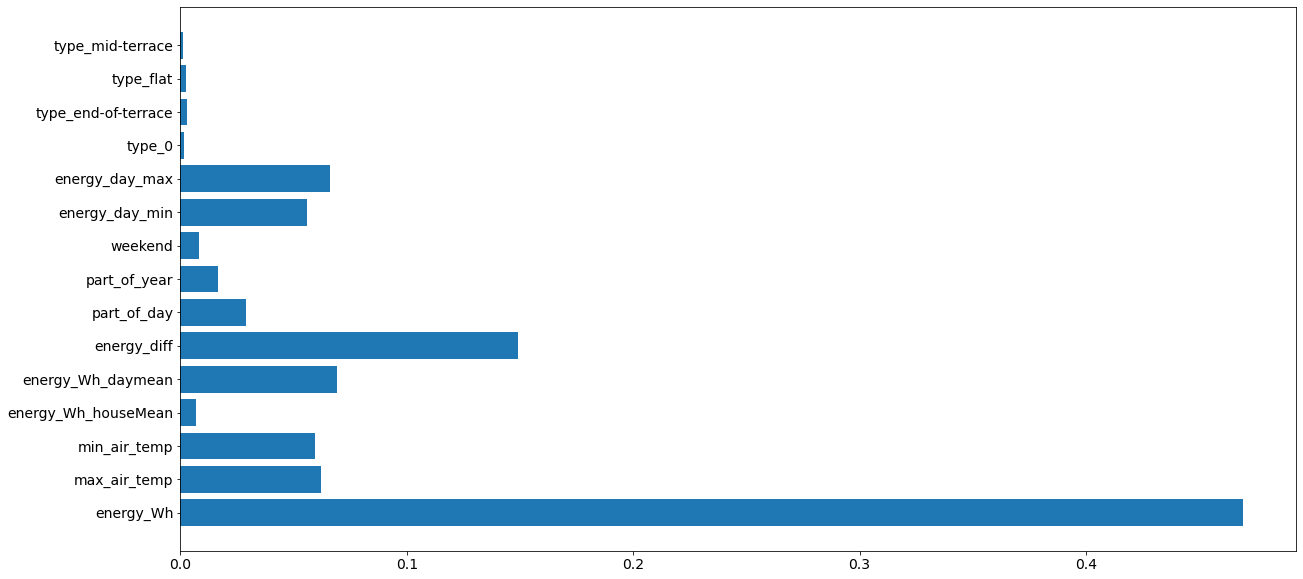

In [71]:
if granularity == '5min':
  feature_names = ['energy_Wh','max_air_temp','min_air_temp','energy_Wh_houseMean','energy_Wh_daymean','energy_diff',\
                  'part_of_day','part_of_year','weekend','energy_day_min','energy_day_max','type_0','type_end-of-terrace','type_flat','type_mid-terrace']
  forest = RandomForestRegressor(n_estimators=10)
  forest.fit(x,y)
  importances = forest.feature_importances_

  forest_importances = pd.DataFrame(importances, index=feature_names,columns=['importance']).sort_values('importance',ascending=False)

  plt.rcParams.update({'figure.figsize': (20, 10.0)})
  plt.rcParams.update({'font.size': 14})
  plt.barh(feature_names, importances)

- Making predictions with the models, so I can later plot them on a graph.
- Predictions and graphs are made predicting one hour into the future.

In [72]:
if granularity == '5min': 
  houses = reload_data(name_tag)[2]

kfold = KFold(n_splits=4, shuffle=True, random_state=0)
predictions_1=predictions_2=predictions_3=predictions_4=predictions_5=np.ndarray(0)
house_predictions = [predictions_1,predictions_2,predictions_3,predictions_4,predictions_5]

if granularity == '5min':
  for i in range(0,len(houses),1):
    house_predictions[i] = cross_val_predict(xgb.XGBRegressor(verbose=1,gamma=0,max_depth=25,min_child_weight=13,n_jobs=-1,n_estimators=10),\
                                        houses[str(i+1)].drop(['energy_next_hour','energy_hour_2','energy_hour_3','energy_5_min','energy_10_min','energy_15_min'],axis=1),\
                                        houses[str(i+1)]['energy_next_hour'], cv=kfold,n_jobs=-1,verbose=1)
if granularity == '60min':
  for i in range(0,len(houses),1):
    house_predictions[i] = cross_val_predict(xgb.XGBRegressor(verbose=1,gamma=0,max_depth=25,min_child_weight=13,n_jobs=-1,n_estimators=10),\
                                        houses[str(i+1)].drop(['energy_next_hour','energy_hour_2','energy_hour_3'],axis=1),\
                                        houses[str(i+1)]['energy_next_hour'], cv=kfold,n_jobs=-1,verbose=1)

for i in range(0,len(houses),1):
  house_predictions[i] = pd.DataFrame({'real':houses[str(i+1)].energy_next_hour,'pred':house_predictions[i]})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.7s finished


- Choosing a one week period in the data, so I can see the details in the lineplot, otherwise the data is too dense.

In [73]:
# function drops index row, for graphing purposes
def drop_index(dataset):
  dataset = dataset.reset_index()
  return dataset.drop(['index'], axis=1)

# dataset for lineplot
def make_lineplot(data, start_week, end_week):
  lineplot = {}
  i = 1
  for p in data:
    lineplot['House_'+str(i)] = p[start_week*168 : end_week*168]
    lineplot['House_'+str(i)] = drop_index(lineplot['House_'+str(i)])
    i+=1
  return lineplot

# dataset for kdeplot
def make_kdeplot(data):
  kdeplot = {}
  i = 1
  for p in data:
    kdeplot['House_'+str(i)] = p
    i+=1
  return kdeplot

def draw_kdeplot(house_data):
  plt.figure(figsize=(15,15))
  sns.kdeplot(x=house_data['real'],data=house_data)
  sns.kdeplot(x=house_data['pred'],data=house_data)
  plt.legend(['real','predicted'])

def draw_lineplot(house_data):
  plt.figure(figsize=(15,15))
  sns.lineplot(x=house_data.index,y=house_data['real'],data=house_data)
  sns.lineplot(x=house_data.index,y=house_data['pred'],data=house_data)
  plt.legend(['real','predicted'])

In [74]:
lineplot = make_lineplot(house_predictions, 0, 2)
kdeplot = make_kdeplot(house_predictions)

- KDE plots for each house.
  - Similar to the HUE data, again all plots show a common trait and that is, that they have two peaks in values. Although here I noticed that my model really overshoots the first peak and overall the prediction graph is slightly shifted to the left, which would mean that in general I undershoot the prediction. 

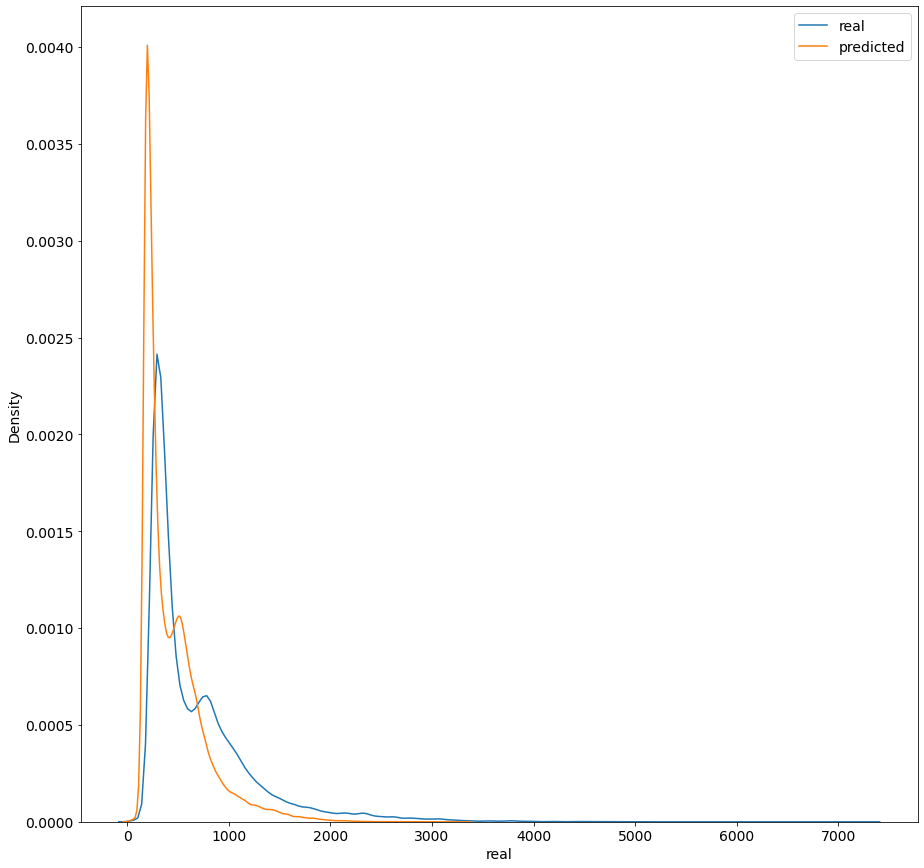

In [75]:
draw_kdeplot(kdeplot['House_1'])

In [ ]:
draw_kdeplot(kdeplot['House_2'])

In [ ]:
draw_kdeplot(kdeplot['House_3'])

In [ ]:
draw_kdeplot(kdeplot['House_4'])

In [ ]:
draw_kdeplot(kdeplot['House_5'])

- Lineplots of a one week period, including the real values of energy consumption and the predictions for each house.
  - For this dataset I decided to show the graphs using XGBRegressor. I am quite happy with the general shape of the graph, although again I can clearly see that predictions aren't "flexible" enough in other words, I am undershooting the "peaks" of consumption and overshooting the "valleys". But even more obvious is that in general all my predictions are too low. I will try to fix that by writing a custom loss function, which will hopefully just shift the graph up.
  - I also graphed out the results using RandomForestRegressor, although the graphs were alot better, because the fit was alot better I could still notice the "flexibility" problem, that I cannot fix.

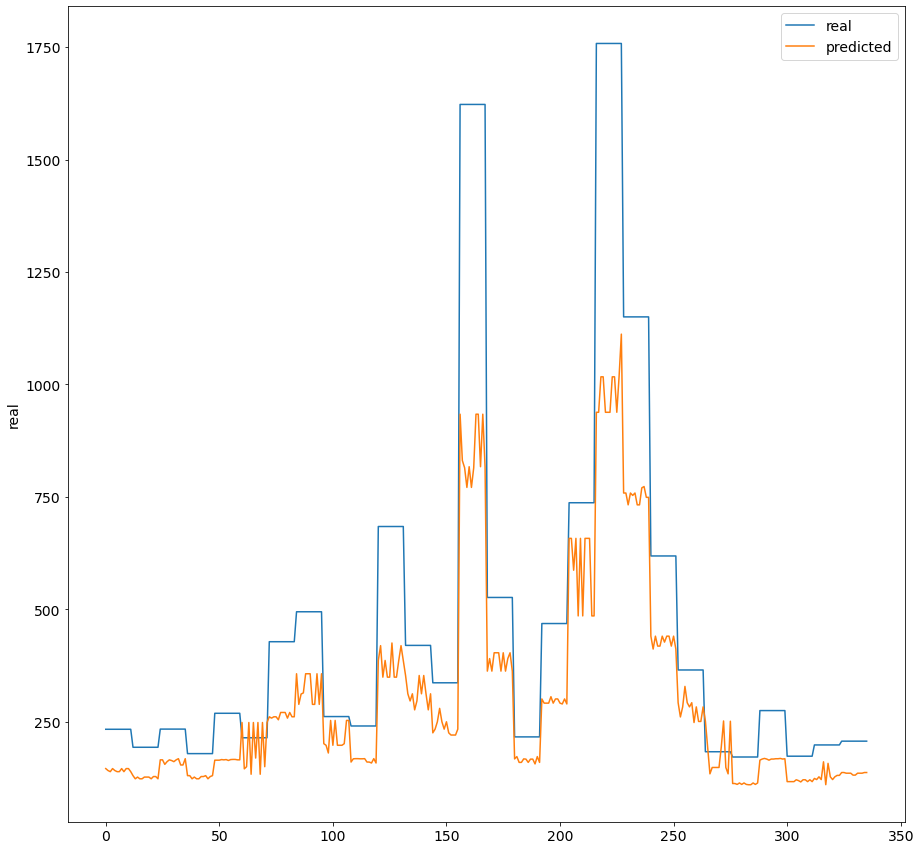

In [76]:
draw_lineplot(lineplot['House_1'])

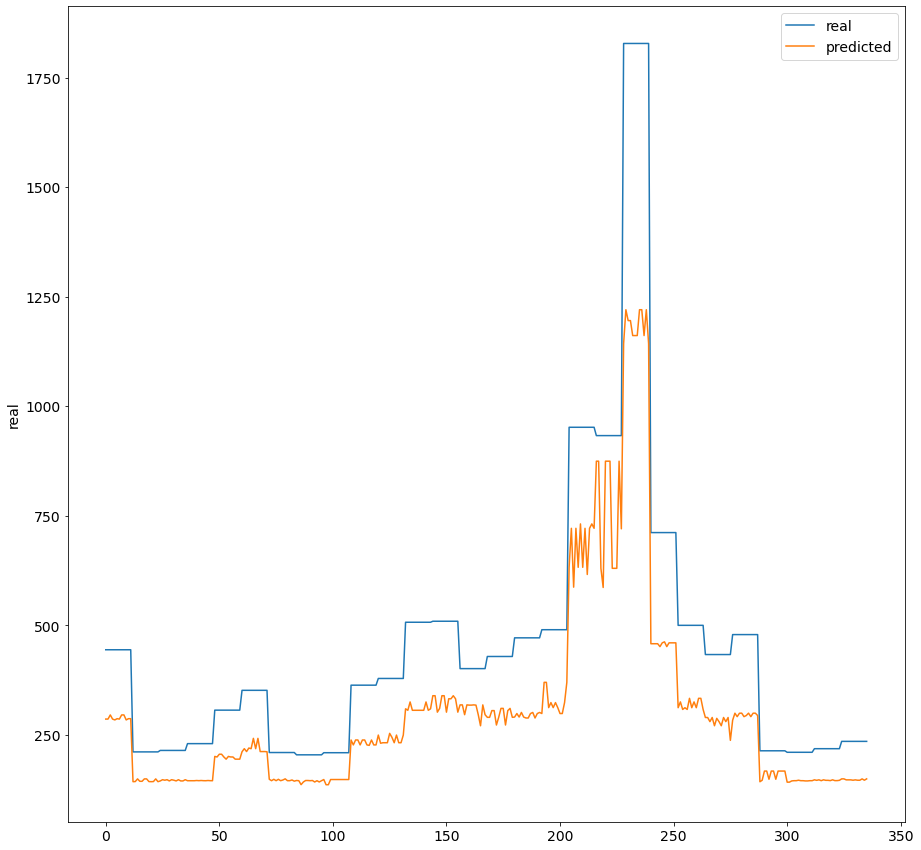

In [77]:
draw_lineplot(lineplot['House_2'])

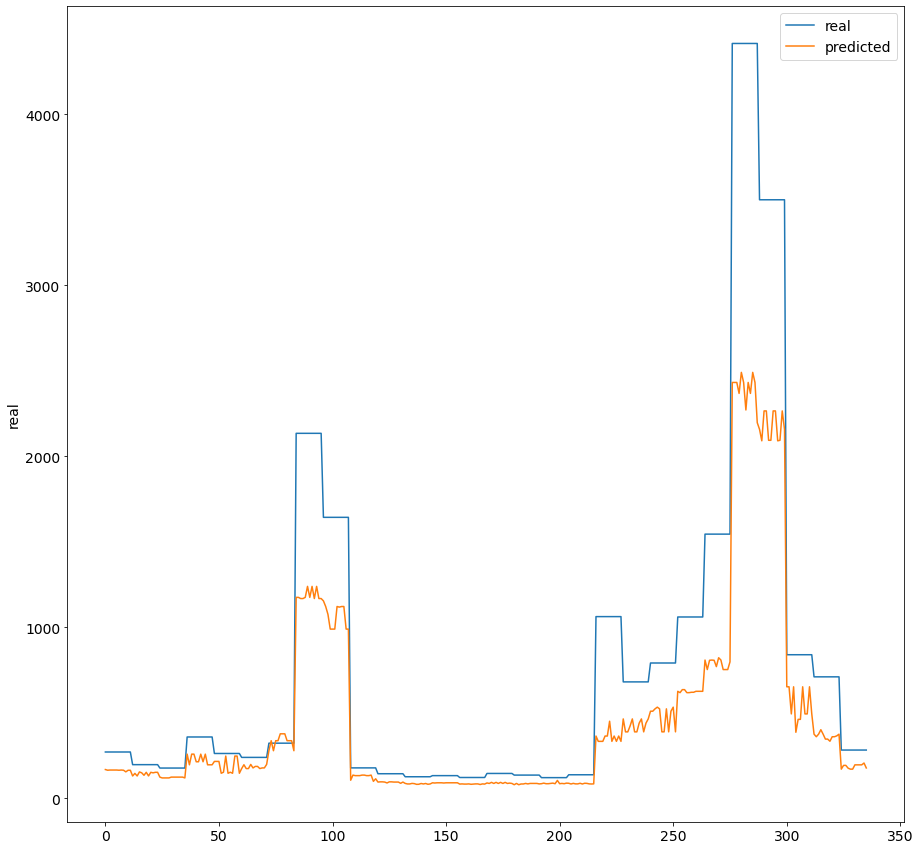

In [78]:
draw_lineplot(lineplot['House_3'])

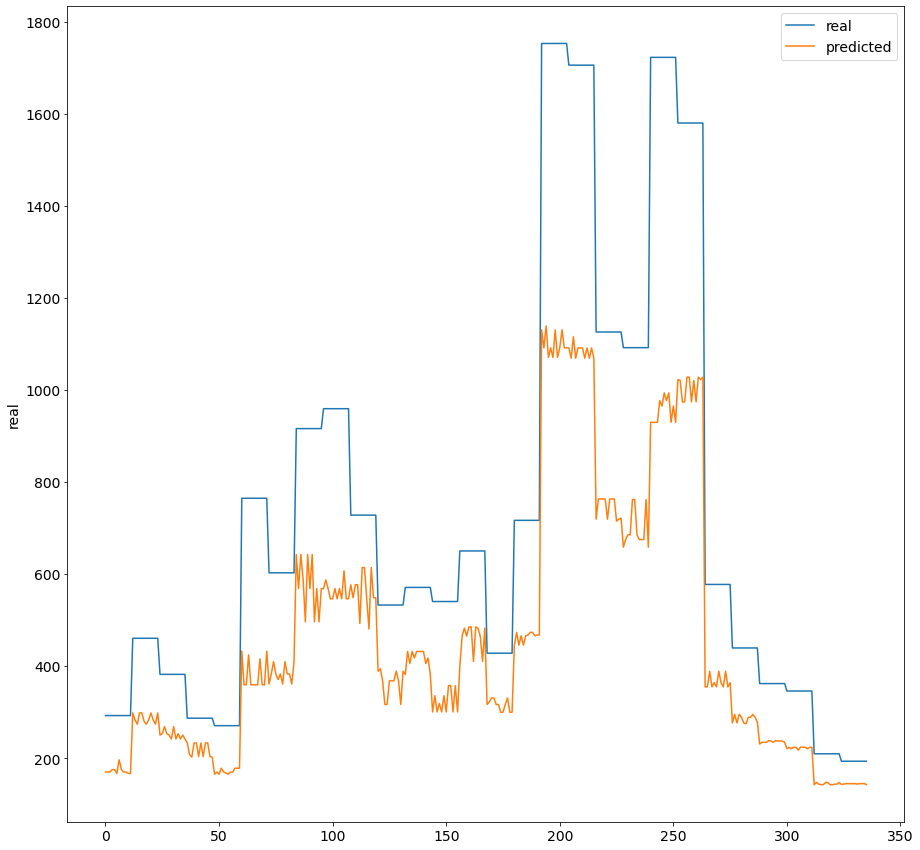

In [79]:
draw_lineplot(lineplot['House_4'])

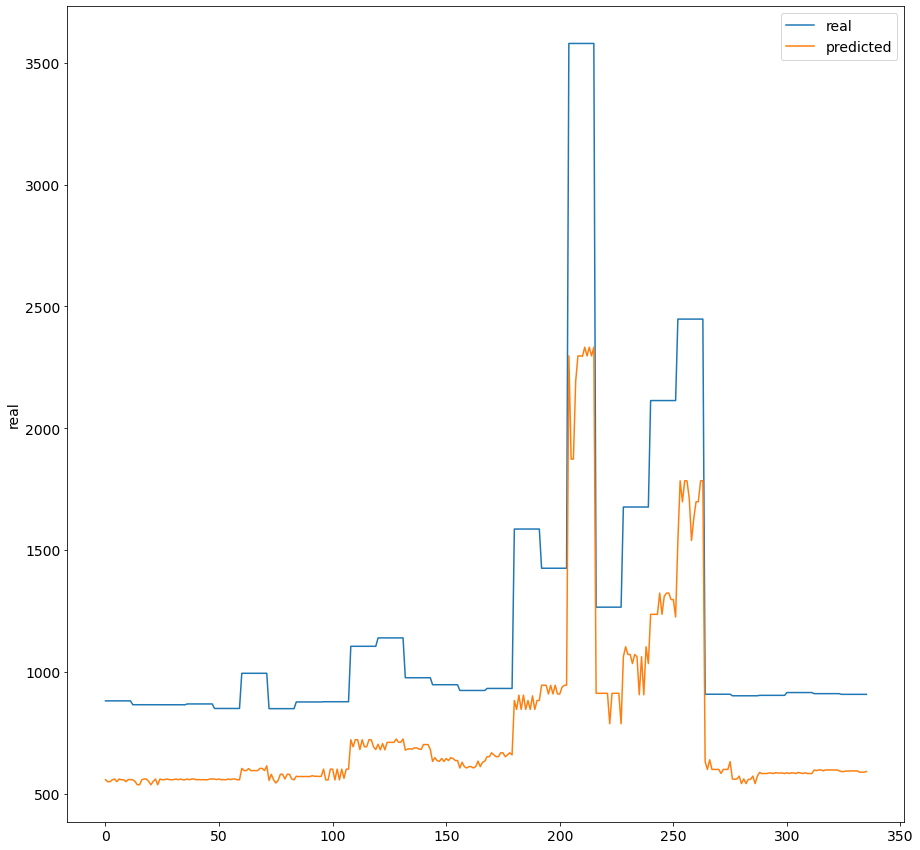

In [80]:
draw_lineplot(lineplot['House_5'])